Inspired by the follwing video : https://www.youtube.com/watch?v=Uz3B9fVb4LQ

# 0. Import Python libraries

In [11]:
#math
import numpy as np
import sympy as sy
#vis
import matplotlib.pyplot as plt

# 1. $f$, $\nabla f$ and $\nabla^2 f$ definition

In [12]:
"""This section enables to express f (objective function), its gradient vector and hessian matrix symbolically and evaluate them at specific coordinates.
To do so, express analititically f by indexing the symbolic variable x. For instance x[0] represent first dimension, x[1] the second and so on.
grad_f_exp and hess_f_exp are only there to automatically differentiate f_exp. To evaluate the f, grad_f or hess_f functions, call them precising the desirated coordinates.
This evaluation use lambdify function and uses "numpy" format.

    Parameters
    ----------
    x : sympy.IndexedBase
        symbolic variable managing indexes. For instance, instead of declaring n variable for the n dimensions (x, y, z, ...) which isn't easily scalable, 
        here variables are automaticly indexed (x_1, x_2, ..., x_n).

    xk : np.array (float)
        Coordinates to evaluate the function.

    Returns
    -------
    numpy.float (scalar or numpy.array)
        Depending on the considered function, return a scalar, a (n, ) vector or a (n, n) array.

    Notes
    ------
    The use of specific function to express f, grad_f and hess_f is to improve scalability in the case of not having analitic expression.
    For instance, when only have a black box model which evaluate f, grad_f (and hess_f). 

    References
    ------
    https://docs.sympy.org/latest/index.html

    Examples
    ------
    >>>x = sy.IndexedBase('x')
    >>>xk = [-4, 3]
    >>>dk = grad_f(x, xk)
    """

def f_exp(x):
    return 3*x[0]**2 + 2*x[1]**2 + 20*sy.cos(x[0])*sy.cos(x[1])+40

def f(x, xk):
    return sy.lambdify(x, f_exp(x), "numpy")(xk)

def grad_f_exp(x, xk):
    return [sy.diff(f_exp(x), x[i]) for i in range(len(xk))]

def grad_f(x, xk):
    lambdify = [sy.lambdify(x, gf, "numpy") for gf in grad_f_exp(x, xk)]
    return np.array([lambdify[i](xk) for i in range(len(xk))])

def hess_f_exp(x, xk):
    return [[sy.diff(g, x[i]) for i in range(len(xk))] for g in grad_f_exp(x, xk)]

def hess_f(x, xk):
    lambdify = [[sy.lambdify(x, gf, "numpy") for gf in Hs] for Hs in hess_f_exp(x, xk)]
    return np.array([[lambdify[i][j](xk) for i in range(len(xk))] for j in range(len(xk))])

# 2. Armijo rule

In [13]:
class Armijo():
    """Armijo is a class implementing the Armijo's rule using a backtracking method. It has 3 functions in addition to the __init__ function.
    - fit(): is the main function, ensuring the convergency and implementing the backtracking algorithm. It calls phi(), theta() 
    - phi(): is the function to evaluate the first terme of Armijo's rule. It calls the function f() previously defined by the user.
    - theta(): is the function to evaluate the second terme of Armijo's rule. It calls the functions f() and grad_f() previously defined by the user.

    Notes
    ------
    The class respect a commun pattern for all line search classes. To evaluate descent step call the function fit().

    References
    ------
    J. F. Bonnans, J. C. Gilbert, C. Lemaréchal, C. A. Sagastizábal, 2006. Numerical Optimization: Theoretical and Practical Aspects. https://doi.org/10.5860/choice.41-0357
    https://github.com/scikit-learn/scikit-learn

    Examples
    ------
    >>>armijolinesearch = Armijo(x, xk, dk, a0=a0, b=b, w_1=w_1, max_it=max_it)
    >>>m, alpha = armijolinesearch.fit()
    """
    def __init__(
        self,
        x,
        xk,
        dk,
        *,
        w_1=.015,
        a0=15,
        b=.95,
        max_it=50
        ):
        """
        Parameters
        ----------
        x : sympy.IndexedBase
            Previously defined, needed to evaluate phi() and theta()
        xk : np.array (float)
            Coordinates to evaluate the function
        dk : np.array (float)
            direction descent at iteration k
        w_1 : float, optional
            hyperparameter defining Armijo's condition, by default .015
        a0 : int, optional
            hyperparameter defining initial guess of a (biggest), by default 15
        b : float, optional
            hyperparameter defining the backtracking geometric convergency, by default .95
        max_it : int, optional
            hyperparameter defining maximum of iteration, by default 50
        """
        self.x = x
        self.xk = xk
        self.dk = dk
        self.a0 = a0
        self.b = b
        self.w_1 = w_1
        self.max_it = max_it

    def phi(Armijo, m):
        phi = f(Armijo.x, Armijo.xk + Armijo.b**m * Armijo.a0 * Armijo.dk)
        return phi

    def theta(Armijo, m):
        theta = f(Armijo.x, Armijo.xk) + Armijo.w_1 * Armijo.b**m * Armijo.a0 * np.dot(grad_f(Armijo.x, Armijo.xk), Armijo.dk)
        return theta
    
    def fit(Armijo):
        """fit Run until max iteration is reached (not converged) or a respecting Armijo's rule step is found.

        Returns
        -------
        list(int, float): [m, a]
            Returns both iteration steps needed and a respecting Armijo's rule step.
        """
        m = 0
        while(m <= Armijo.max_it):
            if Armijo.phi(m) <= Armijo.theta(m):
                break
            else:
                m += 1

            if(m==Armijo.max_it):
                print(m)
                print('a didn\'t converged')

        a = Armijo.a0 * Armijo.b**(m)
        return [m, a]

In [14]:
#symbolic variable definition
x = sy.IndexedBase('x')

#Armijo hyperparameters
a0 = 15
b = .95
w_1 = .15
max_it = 500

#Armijo input
xk = [-4, 3]
dk = - grad_f(x, xk)/np.linalg.norm(grad_f(x, xk))

#Armijo fit
armijolinesearch = Armijo(x, xk, dk, a0=a0, b=b, w_1=w_1, max_it=max_it)
m, alpha = armijolinesearch.fit()

#print output
print(f"m: {m}")
print(f"alpha: {alpha}")
print(f"dk: {dk}")

m: 9
alpha: 9.453741145869136
dk: [ 0.54568069 -0.83799319]


# 3. Visualization

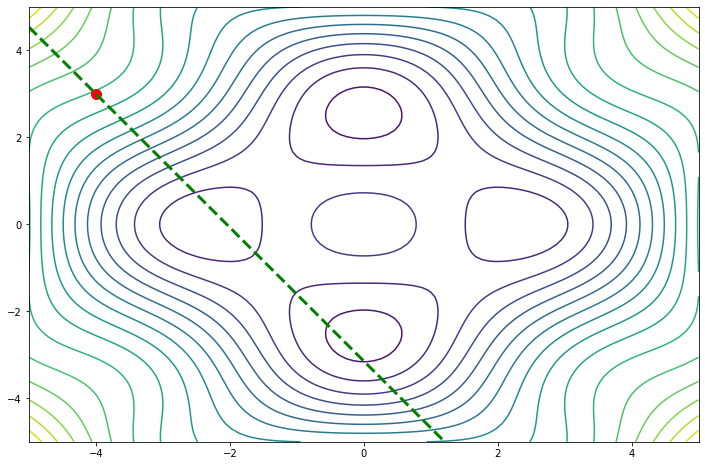

In [15]:
#Create meshgrid
X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)
mesh_X, mesh_Y = np.meshgrid(X, Y)
Z = f(x,[mesh_X,mesh_Y])

#Choose which dimensions to plot
xdim = 0
ydim = 1

#Calculate direction search at xk
d = (dk[ydim]/dk[xdim])*(X-xk[xdim]) + xk[ydim]

#plot figure
plt.figure(figsize=(12, 8))
plt.ylim(-5, 5)
plt.xlim(-5, 5)
plt.contour(mesh_X, mesh_Y, Z, 16)
plt.plot(xk[xdim], xk[ydim], 'or', markersize= 10)
plt.plot(X, d, 'g--', linewidth=3)
plt.show()

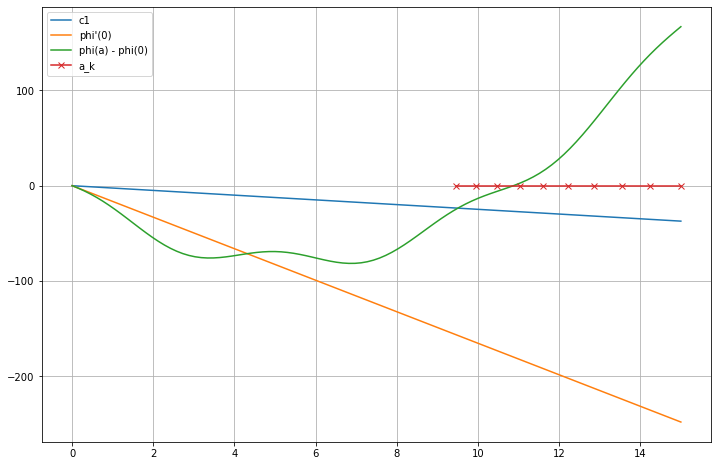

In [16]:
X= np.linspace(0, 15, 100)

#Armijo condition
y1= w_1*np.dot(grad_f(x, xk), dk)*X
#phi'(0)
y2 = np.dot(grad_f(x, xk), dk)*X
#descent response of line search
y3 = [f(x, xk + i*dk) - f(x, xk) for i in X]
#convergence of a
xa = [a0*b**i for i in range(m+1)]

#plot figure
plt.figure(figsize=(12, 8))
plt.grid(visible=True)
plt.plot(X, y1)
plt.plot(X, y2)
plt.plot(X, y3)
plt.plot(xa, np.zeros(len(xa)), marker='x')
plt.legend(['c1', 'phi\'(0)' , 'phi(a) - phi(0)', 'a_k'])
plt.show()